## 0. Introduction
Build a Neural Network
For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression`.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



In [272]:
!pip install torch

In [273]:
!pip install scikit-learn

In [274]:
!pip install numpy

In [275]:
!pip install matplotlib

In [276]:
!pip install seaborn

In [277]:
!pip install pandas

In [278]:
!pip install IPython

In [279]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

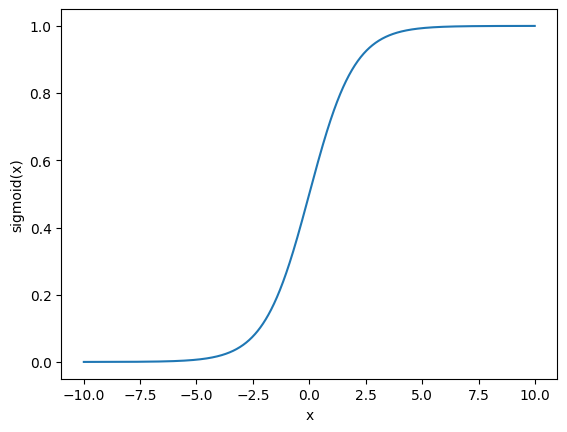

In [280]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  z = 1 / (1 + torch.exp(-z))  
  return z
x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [281]:
## logistic regression class
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1, num_features), requires_grad=False)

  def forward(self, x):
    return sigmoid(torch.matmul(x, self.weight.T))

In [282]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  return torch.mean((-y_true * torch.log(y_pred)) - ((1-y_true) * torch.log(1-y_pred)))

In [283]:
num_features = 5  # Set the number of features according to your dataset
model = LogisticRegression(num_features)

# Example input tensor
input_tensor = torch.randn(10, num_features)

# Forward pass through the model
output = model(input_tensor)

# Display the output
print("Model output:", output)

Model output: tensor([[0.5002],
        [0.6424],
        [0.3465],
        [0.2825],
        [0.8269],
        [0.6652],
        [0.6165],
        [0.4538],
        [0.7289],
        [0.3928]])


# 1. The XOR problem

Let's revisit the XOR problem.

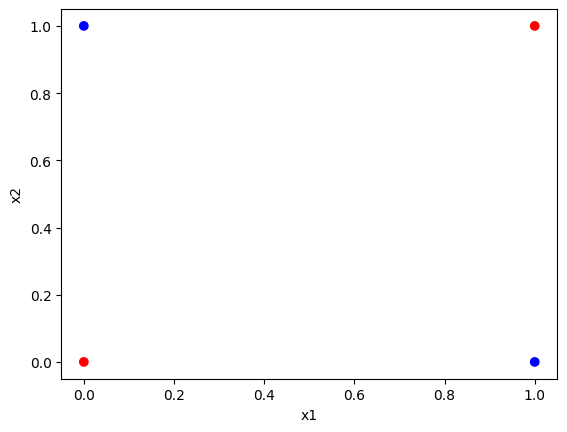

In [284]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

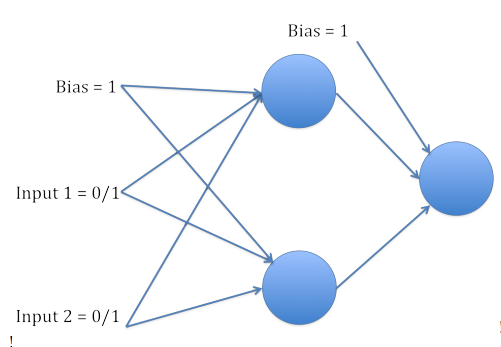

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [285]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs):
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias
    self.y_hidden = torch.ones(len(self.hidden_layer) + 1)
    self.y_output = torch.zeros(num_outputs)

  def forward(self, x: torch.tensor) -> torch.tensor:
    #Forward pass - hidden layer
    self.y_hidden[:2] = torch.cat([l(x) for l in self.hidden_layer], dim=0)

    #Forward pass - output layer
    self.y_output = torch.cat([l(self.y_hidden) for l in self.output_layer], dim=0)

    return self.y_output
  

  def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
    Delta = self.y_output - y
    DSigmoid = self.y_output * (1-self.y_output)
    Deltas = DSigmoid * Delta 


    wt_output_layer = nn.utils.parameters_to_vector(list(self.output_layer.parameters()))

    error = (1 - self.y_hidden) * self.y_hidden * (wt_output_layer * Deltas)
    
    #Adding hidden layer weights
    for i,l in enumerate(self.hidden_layer):
      l.weight[:] -= lr * error[i] * x

    #Adding output layer weights
    for i,l in enumerate(self.output_layer):
      l.weight[:] -= lr * Deltas * self.y_hidden

    return

In [286]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([0.6425])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[0.3168, 0.6965, 0.9143]])
hidden_layer.1.weight Parameter containing:
tensor([[0.9351, 0.9412, 0.5995]])
output_layer.0.weight Parameter containing:
tensor([[0.0652, 0.5460, 0.1872]])

Hidden layer weight matrix:
tensor([[[0.3168, 0.6965, 0.9143]],

        [[0.9351, 0.9412, 0.5995]]])


In the `NeuralNetwork` class above, fill in the `backward_pass()` method.

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to probagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [287]:
# test it works
model.backward_pass(x_test, y_test, 1)

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

torch.Size([4, 3])


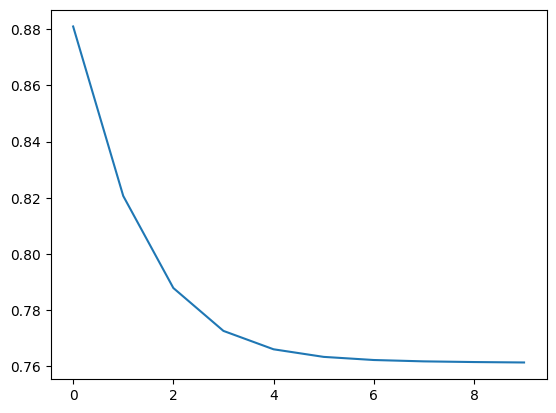

tensor([0., 1., 1., 0.]) tensor([0.4997, 0.4944, 0.4998, 0.0000])


In [288]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])

lr = 1
iterations = 10
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

errors = list()
for ep in range(iterations):
  error = 0
  for i in range(x.shape[0]):
    y_pred = model(x[i])
    error += bce(y[i], y_pred)
    model.backward_pass(x[i], y[i], lr)
  errors.append(error/x.shape[0])
plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[1]):
  y_pred[i] = model(x[i])
print(y, y_pred)

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [289]:
from sklearn import datasets, model_selection
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.neural_network import MLPClassifier


In [290]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [291]:
from sklearn import model_selection
import torch

# Assuming iris is already loaded
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
)

x_train = torch.from_numpy(X_train).float()
x_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test).int()
y_test = y_test.reshape(-1, 1)


In [292]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  z = (x - mu)/ sigma
  return z

# Calculate mean and std
x_train_mean = x_train.mean(dim=0)
x_train_std = x_train.std(dim=0)

x_train_norm = norm_set(x_train, x_train_mean, x_train_std)
x_test_norm = norm_set(x_test, x_train_mean, x_train_std)

In [293]:
print("x_train.shape : ", x_train.shape)
print("y_train.shape : ", y_train.shape)

print("x_test.shape : ", x_test.shape)
print("y_test.shape : ", y_test.shape)

# one hot encoding for y_train
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)

print("y_train.shape after one hot encoding : ", y_train.shape)
print("y_test.shape after one hot encoding : ", y_test.shape)

x_train.shape :  torch.Size([120, 4])
y_train.shape :  torch.Size([120, 1])
x_test.shape :  torch.Size([30, 4])
y_test.shape :  torch.Size([30, 1])
y_train.shape after one hot encoding :  torch.Size([120, 3])
y_test.shape after one hot encoding :  torch.Size([30, 3])


In [294]:
### your code here
class IrisClassifier(nn.Module):
    def __init__(self, n_inputs, n_hidden_nuerons, n_outputs):
        super().__init__()
        self.hidden_layer = nn.Linear(n_inputs, n_hidden_nuerons)
        self.output_layer = nn.Linear(n_hidden_nuerons, n_outputs)


    def forward(self, x):
        # forward pass through the hidden layer
        x = self.hidden_layer(x)
        x = torch.sigmoid(x)
        # forward pass through the output layer
        x = self.output_layer(x)
        x = torch.sigmoid(x)

        # predicted class out of 3
        # print("x.shape : ", x.shape)
        # print("x : ", x)
        # x = torch.argmax(x, dim=1)
        
        return x

/tmp/ipykernel_88/660745387.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float)
/tmp/ipykernel_88/660745387.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float)


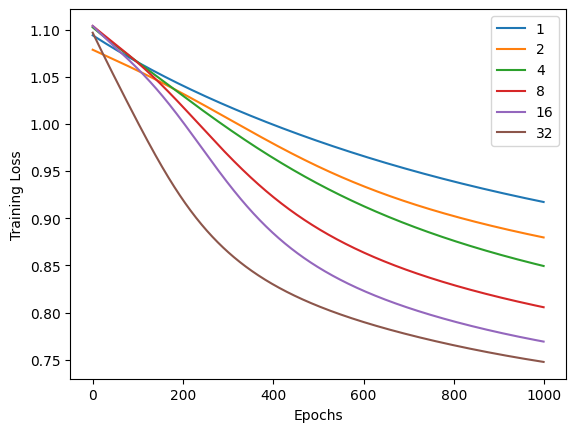

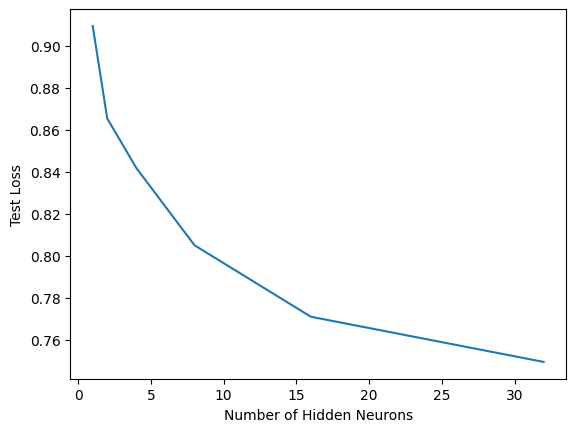

test_loss :  [0.9094139337539673, 0.8654096126556396, 0.8418328166007996, 0.8050715923309326, 0.7710891366004944, 0.7495952248573303]


In [295]:
hidden_nuerons_list = [1, 2, 4, 8, 16, 32]
# hidden_nuerons_list = [1, 2]
lr = 0.1
n_outputs = 3

test_loss = []
training_loss_neurons = []

y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

for n_hidden_nuerons in hidden_nuerons_list:
    n_inputs = x_train_norm.shape[1]
    model = IrisClassifier(n_inputs=n_inputs, n_hidden_nuerons=n_hidden_nuerons, n_outputs=n_outputs)
    optim = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    epochs = 1000
    training_loss = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(x_train_norm)
        loss = criterion(y_pred, y_train)
        # loss = F.binary_cross_entropy(y_pred, y_train.float())
        loss.backward()

        optim.step()
        optim.zero_grad()
        training_loss.append(loss.item())

        # if (epoch+1) % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    training_loss_neurons.append(training_loss)

    with torch.no_grad():
        model.eval()
        y_pred_test = model(x_test_norm)
        loss_test = criterion(y_pred_test, y_test)
        # loss_test = F.binary_cross_entropy(y_pred_test, y_test.float())
        # loss_test = bce(y_test.float(), y_pred_test)
        test_loss.append(loss_test.item())

# Plot training loss for each hidden neuron
for i, n_hidden_nuerons in enumerate(hidden_nuerons_list):
    plt.plot(list(range(epochs)), training_loss_neurons[i], label=n_hidden_nuerons)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

# Plot the test loss in new figure
plt.plot(hidden_nuerons_list, test_loss)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Test Loss')
plt.show()

print("test_loss : ", test_loss)
# print("training_loss_neurons : ", training_loss_neurons)

## Exploring Further - Performance metrics

In [296]:
# Split the data into train and test sets using the same random seed
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
)

x_train = torch.from_numpy(X_train).float()
x_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test).int()
y_test = y_test.reshape(-1, 1)


# Normalize the data
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    z = (x - mu) / sigma
    return z

# Calculate mean and std
x_train_mean = x_train.mean(dim=0)
x_train_std = x_train.std(dim=0)

x_train_norm = norm_set(x_train, x_train_mean, x_train_std)
x_test_norm = norm_set(x_test, x_train_mean, x_train_std)

In [297]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

#Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Training model with 1 hidden neurons:
Minimum train cost: 0.5651211142539978
Minimum test cost:  0.5657119154930115
Performance Metrics (hidden_neurons=1):
Metric          Value          
------------------------------
Accuracy        0.7333
Precision       0.8456
Recall          0.7333
F1 Score        0.6622


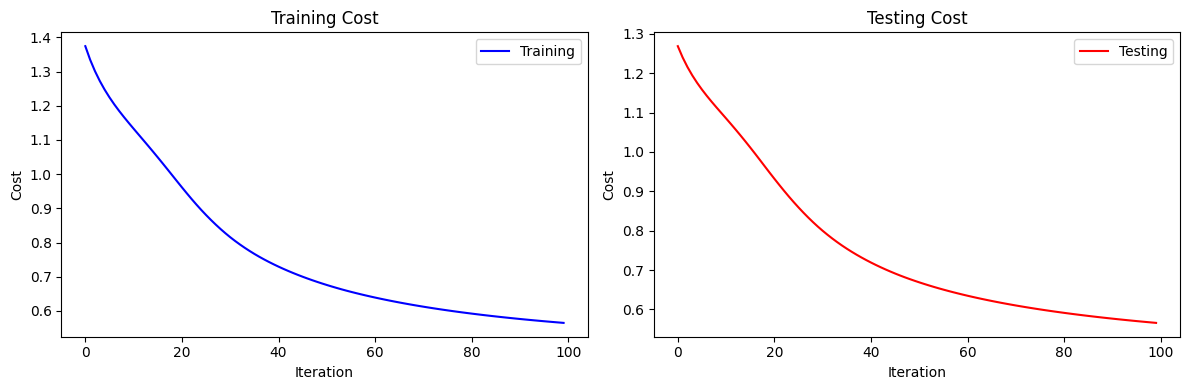

Training model with 2 hidden neurons:
Minimum train cost: 0.4550947844982147
Minimum test cost:  0.4433414340019226
Performance Metrics (hidden_neurons=2):
Metric          Value          
------------------------------
Accuracy        0.9333
Precision       0.9333
Recall          0.9333
F1 Score        0.9333


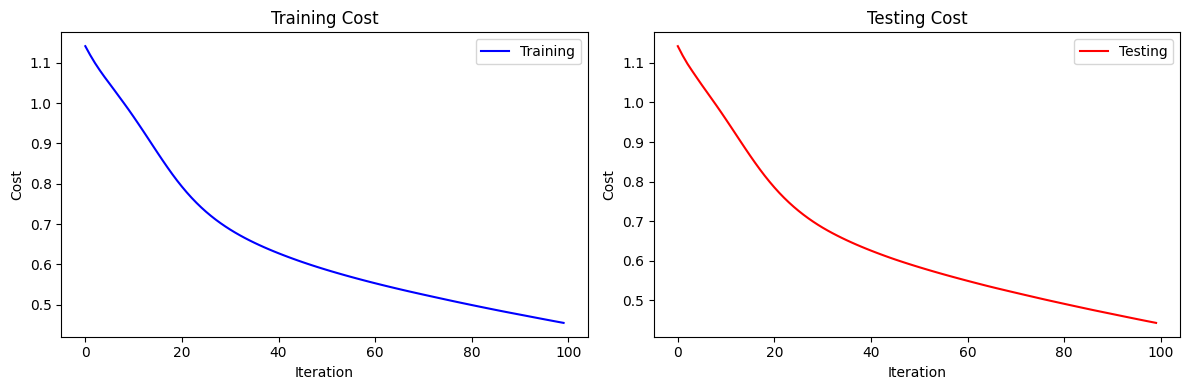

Training model with 4 hidden neurons:
Minimum train cost: 0.44008687138557434
Minimum test cost:  0.4147793650627136
Performance Metrics (hidden_neurons=4):
Metric          Value          
------------------------------
Accuracy        0.7667
Precision       0.8574
Recall          0.7667
F1 Score        0.7206


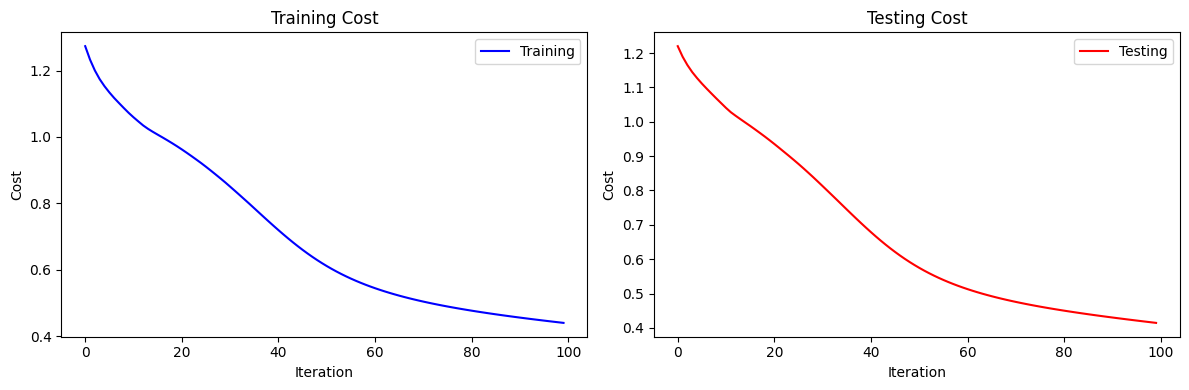

Training model with 8 hidden neurons:
Minimum train cost: 0.4062647223472595
Minimum test cost:  0.3507208228111267
Performance Metrics (hidden_neurons=8):
Metric          Value          
------------------------------
Accuracy        0.9333
Precision       0.9436
Recall          0.9333
F1 Score        0.9319


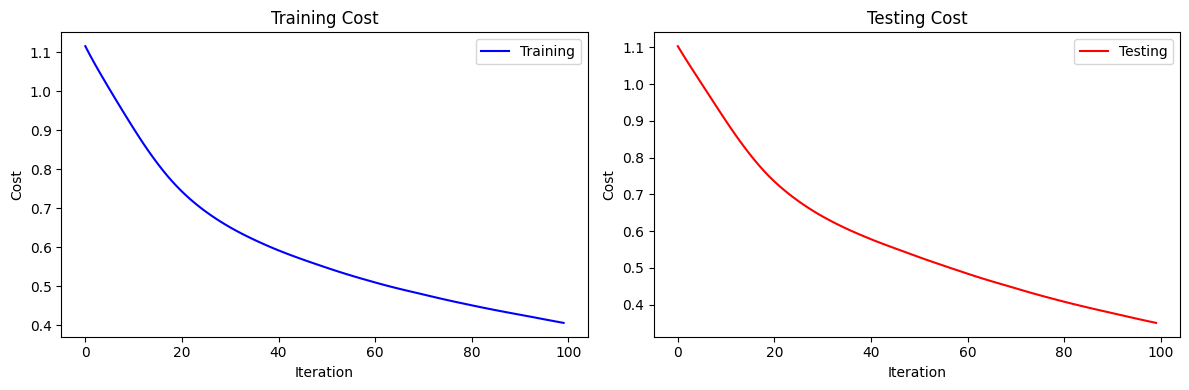

Training model with 16 hidden neurons:
Minimum train cost: 0.26003366708755493
Minimum test cost:  0.21042318642139435
Performance Metrics (hidden_neurons=16):
Metric          Value          
------------------------------
Accuracy        0.9667
Precision       0.9694
Recall          0.9667
F1 Score        0.9664


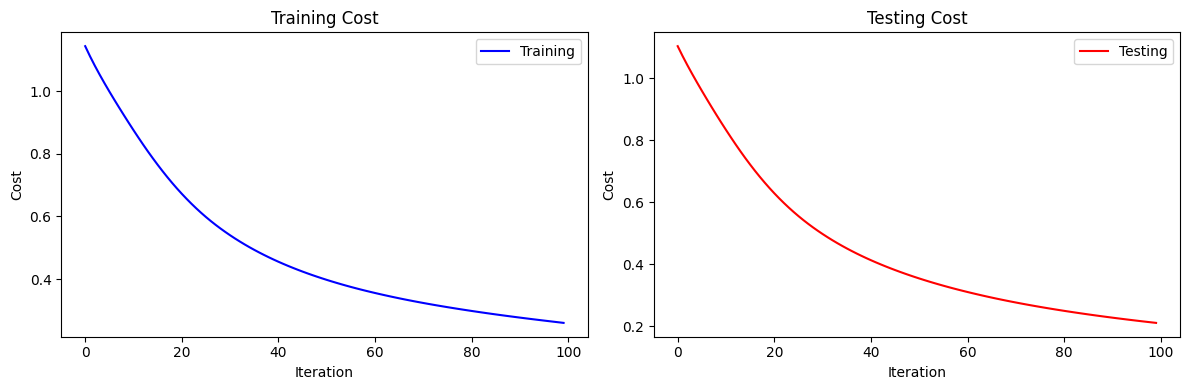

Training model with 32 hidden neurons:
Minimum train cost: 0.22393931448459625
Minimum test cost:  0.16343441605567932
Performance Metrics (hidden_neurons=32):
Metric          Value          
------------------------------
Accuracy        0.9667
Precision       0.9694
Recall          0.9667
F1 Score        0.9664


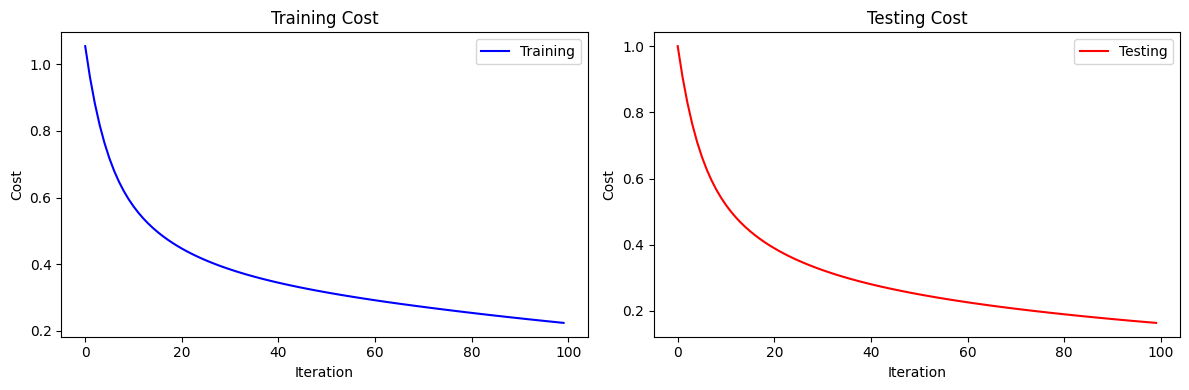

In [298]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred.argmax(dim=1))
    precision = precision_score(y_true, y_pred.argmax(dim=1), average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred.argmax(dim=1), average='weighted')
    f1 = f1_score(y_true, y_pred.argmax(dim=1), average='weighted')
    return accuracy, precision, recall, f1

def print_metrics_table(model, test_x, test_y):
    model.eval()
    with torch.no_grad():
        test_pred = model(test_x)
        
        #Calculate performance metrics
        accuracy, precision, recall, f1 = calculate_metrics(test_y, test_pred)

        #Print performance metrics in a table
        print(f"\033[1mPerformance Metrics (hidden_neurons={model.fc1.out_features}):\033[0m")
        print("{:<15} {:<15}".format("Metric", "Value"))
        print('-' * 30)
        print("{:<15} {:.4f}".format("Accuracy", accuracy))
        print("{:<15} {:.4f}".format("Precision", precision))
        print("{:<15} {:.4f}".format("Recall", recall))
        print("{:<15} {:.4f}".format("F1 Score", f1))

def train(model, x, y, test_x, test_y, optimizer, alpha):
    train_lst = []
    test_lst = []

    for i in range(100):
        model.train()
        optimizer.zero_grad()
        pred = model(x)
        cost = F.cross_entropy(pred, y.squeeze(), reduction='mean')
        cost.backward()
        optimizer.step()

        train_lst.append(cost.item())

        model.eval()
        with torch.no_grad():
            test_pred = model(test_x)
            test_cost = F.cross_entropy(test_pred, test_y.squeeze(), reduction='mean')
            test_lst.append(test_cost.item())

    # Print training and testing costs
    print("\033[1mMinimum train cost:\033[0m {}".format(min(train_lst)))
    print("\033[1mMinimum test cost: \033[0m {}".format(min(test_lst)))

    # Call the function to print the performance metrics table
    print_metrics_table(model, test_x, test_y)

    # Plot training and testing costs
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})

    axs[0].plot(list(range(i+1)), train_lst, color='blue', label='Training')
    axs[0].set_title('Training Cost')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Cost')
    axs[0].legend()

    axs[1].plot(list(range(i+1)), test_lst, color='red', label='Testing')
    axs[1].set_title('Testing Cost')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Cost')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#Setting hyperparameters
alpha = 0.1
hidden_neurons_list = [1, 2, 4, 8, 16, 32]

# Train models with varying numbers of hidden neurons
for hidden_neurons in hidden_neurons_list:
    print(f"\033[1mTraining model with {hidden_neurons} hidden neurons:\033[0m")
    
    # Create an MLP model with the specified number of hidden neurons
    model = MLPClassifier(input_size=x_train_norm.shape[1], hidden_size=hidden_neurons, output_size=3)
    
    # Create an optimizer (Stochastic Gradient Descent) for model parameters
    optimizer = optim.SGD(model.parameters(), lr=alpha)

    # Call the train function to train the model
    train(model, x_train_norm, y_train.long(), x_test_norm, y_test.long(), optimizer, alpha)
